In [1]:
import networkx as nx
# https://networkx.github.io/documentation/stable/reference/index.html
import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
import pandas as pd
from collections import Counter

# Exploration of the graph : relational data understanding

In [2]:
# load the graph
# The graph is an extraction from LinkedIn Social Network
G = nx.read_gexf("mediumLinkedin.gexf")

In [3]:
G.number_of_nodes()

811

In [4]:
# Nb of edges
G.number_of_edges()

1597

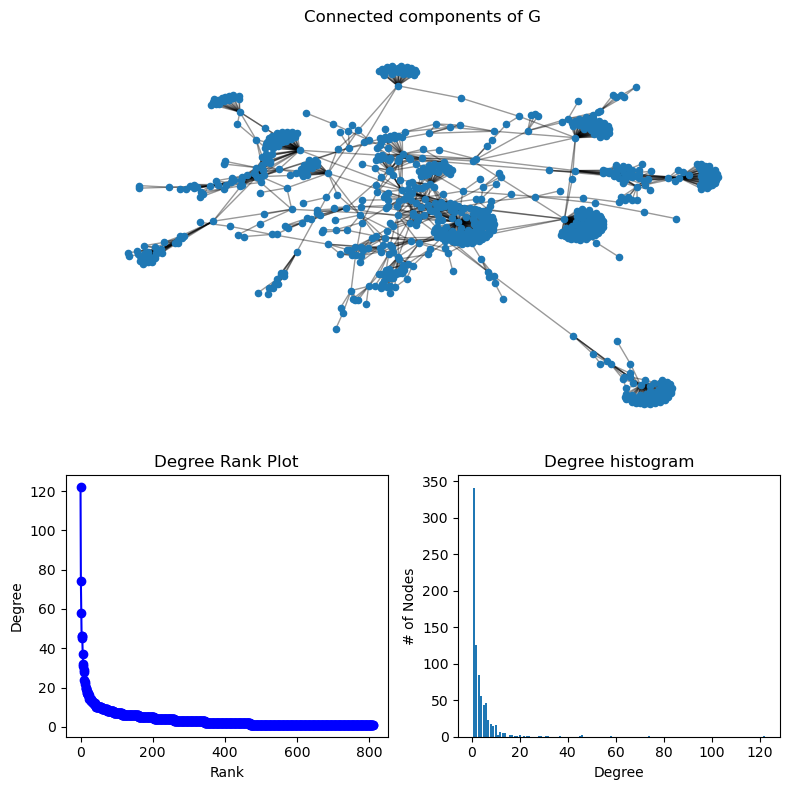

In [5]:
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

# Profil data understanding

In [6]:
# We use pandas dataframes to load attributes
# Nodes are characterized by a list of colleges, a list of employers, a list of location
# The order means nothing. Nothing allow us to determine the current employer...
df_e = pd.read_csv('employer_with_60percent_of_nodes_remoded.csv', sep='\t', header='infer')
df_e.head()

,name,employer
0,U1313,discovery education
1,U1313,ctb mcgraw-hill
2,U1313,university of charleston university of south c...
3,U1313,south carolina department of education
4,U1313,chesapeake va and sumter sc


In [7]:
df_e.groupby('name').count().describe()

,employer
count,297.000000
mean,3.107744
std,1.976682
min,1.000000
25%,1.000000
50%,3.000000
75%,4.000000
max,13.000000


In [8]:
df_e['employer'].value_counts()

university of illinois at urbana-champaign    76
google                                        15
microsoft                                     15
university of texas at austin                  5
amazon                                         5
                                              ..
new jersey department of education             1
brookings institution                          1
syrian emergency task force (setf)             1
muslim public affairs council                  1
yuhuan taijie hardware co. ltd.                1
Name: employer, Length: 723, dtype: int64

In [9]:
# Boolean row selection by values in a column
df_e.loc[df_e['employer'].isin(['google','google inc']),:].head()


,name,employer
30,U3895,google
126,U15289,google
136,U24080,google
145,U24046,google
161,U7151,google


## Now, your turn!

Modify the previous cells, create your own to explore the dataset, and go on with the challenge.

In [10]:
df_all_nodes = pd.read_csv('empty.csv', sep='\t', header='infer')
df_location = pd.read_csv('location_with_60percent_of_nodes_remoded.csv', sep='\t', header='infer')
df_collegue = pd.read_csv('college_with_60percent_of_nodes_remoded.csv', sep='\t', header='infer')

In [11]:
#probleme d'optimisation : traduire en termes percis et définir un critère de réussite

In [12]:
naive_predicted_values={}

In [13]:
empty = df_all_nodes['name'].drop_duplicates().tolist()

In [14]:
def naive_method(graph, empty, df):
    """   Predict the missing attribute with a simple but effective
    relational classifier. 
    
    The assumption is that two connected nodes are 
    likely to share the same attribute value. Here we chose the most frequently
    used attribute by the neighbors
    
    Parameters
    ----------
    graph : graph
       A networkx graph
    empty : list
       The nodes with empty attributes 
    df : pandas dataframe 
       Either location, employer or college dataframe. 

    Returns
    -------
    predicted_values : dict 
       A dict of attributes, either location, employer or college attributes. 
       key is a node (from empty), value is a list of attribute values. Here 
       only 1 value in the list.
     """
    predicted_values={}
    for n in empty:
        nbrs_attr_values=[] 
        for nbr in graph.neighbors(n):
            # attribute values for the node nbr
            attr = df_e.loc[df_e.name == nbr ,'employer'].values
            if attr.size > 0: #array not empty
                for val in attr:
                    nbrs_attr_values.append(val)
        predicted_values[n]=[]
        if nbrs_attr_values: # non empty list
            # count the number of occurrence each value and returns a dict
            cpt=Counter(nbrs_attr_values)
            # take the most represented attribute value among neighbors
            a,nb_occurrence=max(cpt.items(), key=lambda t: t[1])
            predicted_values[n].append(a)
    return predicted_values

In [15]:
naive_predicted_values = naive_method(G, empty, df_e)
naive_predicted_values

In [16]:
df_e_truth = pd.read_csv('./groundtruth/employer.csv', sep='\t', header='infer')
df_e_truth.head()

,name,employer
0,U21998,illinois college advising corps
1,U21998,victoria amplifiers
2,U21998,university of illinois at chicago
3,U27476,ibm
4,U27476,nyse euronext


In [17]:
def evaluation_accuracy(groundtruth, pred):
    """    Compute the accuracy of your model.

     The accuracy is the proportion of true results.

    Parameters
    ----------
    groundtruth : pandas dataframe 
       Either location, employer or college dataframe. 
    pred : dict 
       A dict of attributes, either location, employer or college attributes. 
       key is a node, value is a list of attribute values. 

    Returns
    -------
    out : float
       Accuracy.
    """
    true_positive_prediction=0
    predicted=0
    for p_key, p_value in pred.items():
        attr = groundtruth.loc[groundtruth.name == p_key ,groundtruth.columns[1]].values
        # if prediction is empty, e.g. [], and so is the groundtruth
        # May happen, we count it as a true prediction
        if not p_value and attr.size == 0:
            true_positive_prediction+=1
            predicted+=1
        # counts the number of good prediction for node p_key
        # here len(p_value)=1 but we could have tried to predict more values
        # if p_value == [], we add 0
        true_positive_prediction += len([c for c in p_value if c in attr])
        predicted += len([c for c in p_value])
    return true_positive_prediction*100/predicted


In [18]:
result=evaluation_accuracy(df_e_truth, naive_predicted_values)
print("%f%% of the predictions are true" % result)
print("Very poor result!!! Try to do better!!!!")

##################################### STEP 1 : Locations Prediction ##########################################

############################# Method 1 : Supervised Machine Learning Algorithm ####################################

In [19]:
def graph_link(dataset):
    neighbor_features_matrix = np.zeros((len(dataset), len(neighbors_dict)))
    print(dataset.shape)
    print(neighbor_features_matrix.shape)
    for i, row in dataset.iterrows():
        name = row['name']
        if name in neighbors_dict:
            neighbors = neighbors_dict[name]
            for j, node in enumerate(neighbors_dict):
                if node in neighbors:
                    neighbor_features_matrix[i, j] = 1

    return neighbor_features_matrix

In [20]:
def remove_location(): 
    nodes_to_remove = []
    for location, count in location_counts.items():
        if count > 50:  # noeuds avec la même location
            # choisir un sous-ensemble de noeuds à retirer
            nodes_to_remove.extend(merged_df[merged_df['location'] == location]['name'].iloc[1:])

    # Retirer les noeuds
    merged_df = merged_df[~merged_df['name'].isin(nodes_to_remove)].reset_index(drop=True)
    return merged_df

In [21]:
# Merge dataframes based on node names
merged_df = pd.merge(df_location, df_e, on='name', how='left')
merged_df = pd.merge(merged_df, df_collegue, on='name', how='left')
merged_df

,name,location,employer,college
0,U1313,norfolk virginia area,discovery education,longwood university
1,U1313,norfolk virginia area,ctb mcgraw-hill,longwood university
2,U1313,norfolk virginia area,university of charleston university of south c...,longwood university
3,U1313,norfolk virginia area,south carolina department of education,longwood university
4,U1313,norfolk virginia area,chesapeake va and sumter sc,longwood university
...,...,...,...,...
1005,U15197,urbana-champaign illinois area,campus information technologies and educationa...,university of illinois at urbana-champaign
1006,U15197,urbana-champaign illinois area,smartplay technologies,university of illinois at urbana-champaign
1007,U27777,china,yuhuan taijie hardware co. ltd.,NaN
1008,U8828,urbana-champaign illinois area,university of illinois at urbana-champaign,NaN


In [22]:
from sklearn.preprocessing import LabelEncoder

# Copier le DataFrame 
merged_df = merged_df.copy()

# Supprimer les lignes avec des informations de localisation manquantes
merged_df.dropna(subset=['location'], inplace=True)

# Encoder les variables catégorielles
label_encoder_location = LabelEncoder()
label_encoder_employer = LabelEncoder()
label_encoder_college = LabelEncoder()

merged_df['location_encoded'] = label_encoder_location.fit_transform(merged_df['location'])
merged_df['employer_encoded'] = label_encoder_employer.fit_transform(merged_df['employer'])
merged_df['college_encoded'] = label_encoder_college.fit_transform(merged_df['college'])

#retrait des location surreprésentées
#merged_df=remove_location(merged_df)

print(merged_df)


        name                        location  \
0      U1313           norfolk virginia area   
1      U1313           norfolk virginia area   
2      U1313           norfolk virginia area   
3      U1313           norfolk virginia area   
4      U1313           norfolk virginia area   
...      ...                             ...   
1005  U15197  urbana-champaign illinois area   
1006  U15197  urbana-champaign illinois area   
1007  U27777                           china   
1008   U8828  urbana-champaign illinois area   
1009   U7199  urbana-champaign illinois area   

                                               employer  \
0                                   discovery education   
1                                       ctb mcgraw-hill   
2     university of charleston university of south c...   
3                south carolina department of education   
4                           chesapeake va and sumter sc   
...                                                 ...   
1005  camp

In [23]:
#### Ajout des locations connues des voisins : 
# Créer une matrice vide avec des noms de colonnes et d'index
node_names = merged_df['name']
unique_nodes = merged_df['name'].unique()
matrix_df = pd.DataFrame(-1, index=node_names, columns=unique_nodes)
neighbors_dict = {node: list(G.neighbors(node)) for node in G.nodes}

# Remplir la matrice avec les localisations des nœuds voisins
for i, row in merged_df.iterrows():
    neighbors = neighbors_dict.get(row['name'], [])  # Obtenir les voisins du nœud actuel
    for neighbor in neighbors:
        # Remplacer la valeur par la localisation si une arête existe entre les deux nœuds
        if neighbor in merged_df['name'].values:
            neighbor_location = merged_df.loc[merged_df['name'] == neighbor, 'location_encoded'].values[0]
            matrix_df.at[row['name'], neighbor] = neighbor_location

# Afficher la matrice
print(matrix_df)


        U1313  U8804  U2649  U7310  U22859  U1417  U25611  U3895  U13005  \
name                                                                       
U1313      -1     -1     -1     -1      -1     -1      -1     -1      -1   
U1313      -1     -1     -1     -1      -1     -1      -1     -1      -1   
U1313      -1     -1     -1     -1      -1     -1      -1     -1      -1   
U1313      -1     -1     -1     -1      -1     -1      -1     -1      -1   
U1313      -1     -1     -1     -1      -1     -1      -1     -1      -1   
...       ...    ...    ...    ...     ...    ...     ...    ...     ...   
U15197     -1     -1     -1     -1      -1     -1      -1     -1      -1   
U15197     -1     -1     -1     -1      -1     -1      -1     -1      -1   
U27777     -1     -1     -1     -1      -1     -1      -1     -1      -1   
U8828      -1     -1     -1     -1      -1     -1      -1     -1      -1   
U7199      -1     -1     -1     -1      -1     -1      -1     -1      -1   

        U26

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score

In [109]:
# Step 3: Utiliser la communaute comme fonctionnalite supplementaire
X = np.concatenate([merged_df['employer_encoded'].values.reshape(-1, 1),
                    merged_df['college_encoded'].values.reshape(-1, 1),
                    graph_link(merged_df),
                    matrix_df.values,
                    merged_df['community'].values.reshape(-1, 1)], axis=1)

# Afficher X
print(X)


(1010, 8)
(1010, 811)
[[186.  42.   0. ...  -1.  -1.   1.]
 [162.  42.   0. ...  -1.  -1.   1.]
 [645.  42.   0. ...  -1.  -1.   1.]
 ...
 [718. 109.   0. ...  -1.  -1.   0.]
 [654. 109.   0. ...  -1.  -1.   2.]
 [723. 109.   0. ...  -1.  -1.   6.]]


In [110]:
y = merged_df['location_encoded']


In [134]:
# 1. Préparation des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#gb_model = GradientBoostingClassifier()
#gb_model.fit(X, y)

ab_model = AdaBoostClassifier(n_estimators=60, learning_rate=0.005,random_state=89)
#ab_model.fit(X_train, y_train)
ab_model.fit(X, y)

AdaBoostClassifier(learning_rate=0.005, n_estimators=60, random_state=89)

trouver les noeuds qui n'ont pas de location

In [122]:
df_location = pd.read_csv('location_with_60percent_of_nodes_remoded.csv', sep='\t', header='infer')
print("initial number of complete locations=",len(df_location))

# Get filled nodes
filled_nodes_location = df_location['name'].drop_duplicates().tolist()

# Find empty nodes
empty_nodes = set(G.nodes()) - set(filled_nodes_location)

print("total number of nodes=",len(G.nodes))
print("total number of emplty nodes=",len(empty_nodes))
#empty_nodes_df = pd.DataFrame({'name': list(empty_nodes)})

initial number of complete locations= 336
total number of nodes= 811
total number of emplty nodes= 475


In [123]:
# Créer un DataFrame à partir de empty_nodes avec les colonnes 'name', 'employer', et 'college'
empty_merged = pd.DataFrame({'name': list(empty_nodes)})
# Merge dataframes based on node name
empty_merged=pd.merge(empty_merged, df_collegue, on='name', how='left')
empty_merged['employer']=None
empty_merged



,name,college,employer
0,U3899,NaN,None
1,U27300,NaN,None
2,U27477,NaN,None
3,U7024,NaN,None
4,U16140,NaN,None
...,...,...,...
470,U19884,NaN,None
471,U3971,NaN,None
472,U18545,NaN,None
473,U4635,NaN,None


In [124]:
# Créer une matrice vide avec des noms de colonnes et d'index
matrix_test_df = pd.DataFrame(-1, index=empty_merged['name'], columns=unique_nodes)

# Remplir la matrice avec les localisations des nœuds voisins
for i, row in empty_merged.iterrows():
    neighbors = neighbors_dict.get(row['name'], [])  # Obtenir les voisins du nœud actuel
    for neighbor in neighbors:
        # Remplacer la valeur par la localisation si une arête existe entre les deux nœuds
        if neighbor in merged_df['name'].values:
            neighbor_location = merged_df.loc[merged_df['name'] == neighbor, 'location_encoded'].values[0]
            matrix_test_df.at[row['name'], neighbor] = neighbor_location

# Afficher la matrice
print(matrix_test_df)


        U1313  U8804  U2649  U7310  U22859  U1417  U25611  U3895  U13005  \
name                                                                       
U3899      -1     -1     -1     -1      -1     -1      -1     -1      -1   
U27300     -1     -1     -1     -1      -1     -1      -1     -1      -1   
U27477     -1     -1     -1     -1      -1     -1      -1     -1      -1   
U7024      -1     -1     -1     36      -1     -1      -1     -1      -1   
U16140     -1     -1     -1     -1      -1     -1      -1     -1      -1   
...       ...    ...    ...    ...     ...    ...     ...    ...     ...   
U19884     -1     -1     -1     -1      -1     -1      -1     -1      -1   
U3971      -1     -1     -1     -1      -1     -1      -1     -1      -1   
U18545     -1     -1     -1     -1      -1     -1      -1     -1      -1   
U4635      -1     -1     -1     -1      -1     -1      -1     -1      -1   
U1284      -1     -1     -1     -1      -1     -1      -1     -1      -1   

        U26

In [125]:

empty_merged['employer_encoded'] = label_encoder_employer.fit_transform(empty_merged['employer'])
empty_merged['college_encoded'] = label_encoder_college.fit_transform(empty_merged['college'])
empty_merged['community'] = empty_merged['name'].map(partition)

# Concaténer les caractéristiques d'employeur, de collège et de voisinage pour empty_merged
X_dataset = np.concatenate([empty_merged['employer_encoded'].values.reshape(-1, 1),
                                  empty_merged['college_encoded'].values.reshape(-1, 1),
                                  graph_link(empty_merged),
                                    matrix_test_df.values, 
                                    empty_merged['community'].values.reshape(-1, 1)], axis=1)
X.shape

(475, 6)
(475, 811)


(1010, 1150)

In [135]:
# Ici, X_new représente les nouvelles données sur lesquelles vous voulez faire des prédictions
#predictions = clf.predict(X_dataset)
predictions = ab_model.predict(X_dataset)
predictions.shape


(475,)

In [136]:
df_truth = pd.read_csv('./groundtruth/location.csv', sep='\t', header='infer')
# Afficher les noms des colonnes dans df_e_truth
print(df_truth.columns)


Index(['name', 'location'], dtype='object')


In [137]:
# Obtenir les prédictions dans leur format original à partir des codes encodés
predicted_locations_adaboost = label_encoder_location.inverse_transform(predictions)

# Créer un DataFrame avec les noms, les prédictions et les vérités terrain
results_df = pd.DataFrame(columns=['name', 'predicted_location', 'ground_truth_location'])

# Parcourir chaque nœud dans empty_merged
for i, row in empty_merged.iterrows():
    # Obtenir le nom du nœud
    node_name = row['name']
    
    # Obtenir la location prédite pour ce nœud
    predicted_location = predicted_locations_adaboost[i]
    
    # Trouver la location vérité terrain correspondant à ce nœud dans df_e_truth
    ground_truth_location = df_truth.loc[df_truth['name'] == node_name, 'location'].values[0]
    
    # Ajouter les résultats à results_df en utilisant la méthode loc pour ajouter une nouvelle ligne
    results_df.loc[len(results_df)] = [node_name, predicted_location, ground_truth_location]
    results_df = results_df.drop_duplicates(subset='name', keep='first')

# Afficher les résultats
print(results_df)


       name              predicted_location           ground_truth_location
0     U3899  urbana-champaign illinois area            greater atlanta area
1    U27300  urbana-champaign illinois area  urbana-champaign illinois area
2    U27477  urbana-champaign illinois area            greater seattle area
3     U7024  urbana-champaign illinois area  urbana-champaign illinois area
4    U16140  urbana-champaign illinois area           brussels area belgium
..      ...                             ...                             ...
470  U19884  urbana-champaign illinois area            greater chicago area
471   U3971  urbana-champaign illinois area              beijing city china
472  U18545  urbana-champaign illinois area        gainesville florida area
473   U4635  urbana-champaign illinois area  urbana-champaign illinois area
474   U1284             greater boston area             portland maine area

[475 rows x 3 columns]


In [139]:
def calcul_nombre_location_distinctes(predicted_location):
# Compter le nombre de predicted_location uniques
    num_unique_predicted_locations = results_df['predicted_location'].nunique()
    return num_unique_predicted_locations

# Afficher le résultat
print("Nombre de predicted_location uniques :", calcul_nombre_location_distinctes(predicted_locations_adaboost))


Nombre de predicted_location uniques : 4


******************************************************** Accurancy ********************************************************

In [138]:
# Calculer le nombre total d'observations
total_samples = len(results_df)

# Calculer le nombre de prédictions correctes
correct_predictions = (results_df['predicted_location'] == results_df['ground_truth_location']).sum()

# Calculer l'accuracy
accuracy = correct_predictions / total_samples

# Afficher l'accuracy
print("Accuracy:", accuracy)


Accuracy: 0.2863157894736842


############################# Method 2 : Louvain Algorithm  on an unweighted graph ####################################

In [63]:
def calcul_accuracy(predicted_locations, nodes_without_location):
    # Initialiser un compteur pour le nombre de nœuds correctement prédits
    correct_predictions_count = 0

    # Calculer le nombre total de nœuds
    total_nodes_count = len(nodes_without_location)

    # Parcourir les prédictions et comparer avec la vérité terrain
    for node, location in predicted_locations.items():
        # Vérifier si le nœud est présent dans la vérité terrain
        if node in df_truth['name'].values:
            # Obtenir la vérité terrain pour ce nœud
            true_location = df_truth[df_truth['name'] == node]['location'].iloc[0]
            # Vérifier si la prédiction correspond à la vérité terrain
            if location == true_location:
                correct_predictions_count += 1

    # Calculer l'accuracy
    accuracy = correct_predictions_count / total_nodes_count
    return accuracy


In [37]:
for node_id in G.nodes():
    if node_id in df_e['name'].values:
        G.nodes[node_id]['employer'] = df_e.loc[df_e['name'] == node_id, 'employer'].values[0]
    if node_id in df_location['name'].values:
        G.nodes[node_id]['location'] = df_location.loc[df_location['name'] == node_id, 'location'].values[0]
    if node_id in df_collegue['name'].values:
        G.nodes[node_id]['college'] = df_collegue.loc[df_collegue['name'] == node_id, 'college'].values[0]

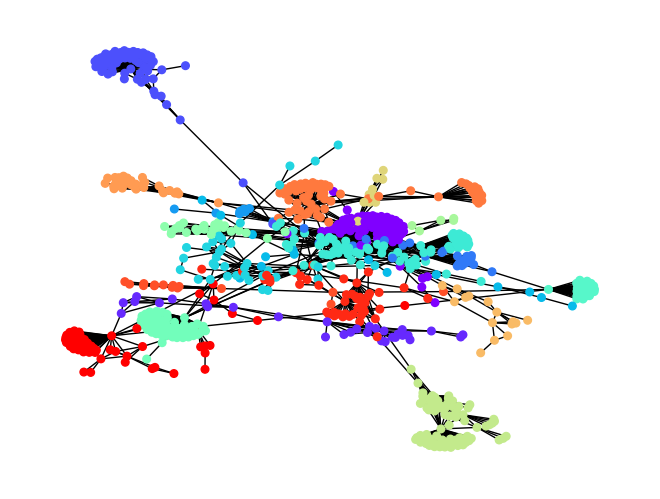

In [85]:
import community
# Appliquer l'algorithme de Louvain en spécifiant le paramètre de résolution
partition = community.best_partition(G)

# Visualisation du graphe avec les communautés colorées
pos = nx.spring_layout(G)
nx.draw(G, pos, node_color=list(partition.values()), with_labels=False, node_size=30, cmap=plt.cm.rainbow)
plt.show()


In [86]:

modularity = community.modularity(partition, G)
print("Modularity:", modularity)

Modularity: 0.8606650933242472


In [87]:
partition_df = pd.DataFrame(partition.items(), columns=['name', 'partition'])

# Fusionnez avec le DataFrame contenant les informations sur les nœuds
merged_ds = pd.merge(partition_df, df_location, on='name', how='left')


# Filtrer les lignes où l'emplacement est manquant
nodes_without_location = merged_ds[merged_ds['location'].isnull()]
#merged_ds['location'] = merged_ds['location'].fillna('')

# Afficher les nœuds sans emplacement
print(nodes_without_location[['name', 'partition']])

       name  partition
0    U27476          0
1     U4665          7
4    U14078          3
5     U9628          6
6     U9721          6
..      ...        ...
804  U27798          0
805  U14564         18
806  U14112          3
807   U4586          7
810  U18520         16

[475 rows x 2 columns]


In [96]:
def find_location(partition, node, node_info):
    # Récupérer la communauté du nœud donné
    community = partition[node]
    
    # Filtrer les nœuds qui ont une communauté valide et une information de localisation associée
    valid_nodes = {n: c for n, c in partition.items() if isinstance(c, int) and n in node_info}
    
    # Collecter toutes les informations de localisation de tous les nœuds dans cette communauté, y compris NaN
    community_locations = [node_info.get(n) for n, c in valid_nodes.items() if c == community]
    
    # Filtrer les valeurs None et NaN
    community_locations = [loc for loc in community_locations if loc is not None and not pd.isnull(loc)]
    
    # Calculer le vote majoritaire pour la localisation
    if community_locations:
        location_votes = {}
        for location in community_locations:
            if location in location_votes:
                location_votes[location] += 1
            else:
                location_votes[location] = 1

        # Trouver la localisation avec le plus de votes
        max_votes = max(location_votes.values())
        most_voted_location = [location for location, votes in location_votes.items() if votes == max_votes]

        return most_voted_location[0] if most_voted_location else None
    else:
        return None


# Créer un dictionnaire de nœuds et de leurs informations associées
node_info = dict(zip(merged_ds['name'], merged_ds['location']))

# Identifier les nœuds sans information de localisation
nodes_without_location = merged_ds[merged_ds['location'].isnull()]

# Remplacer les valeurs NaN dans la colonne "location" pour les nœuds sans information de localisation
for node in nodes_without_location['name']:
    location = find_location(partition, node, node_info)
    node_info[node] = location

# Utiliser ce dictionnaire dans la boucle pour obtenir les prédictions de localisation
predicted_locations_unweighted = {}

for node in nodes_without_location['name']:
    location = find_location(partition, node, node_info)
    predicted_locations_unweighted[node] = location

print(predicted_locations_unweighted)



{'U27476': 'urbana-champaign illinois area', 'U4665': 'urbana-champaign illinois area', 'U14078': 'urbana-champaign illinois area', 'U9628': 'urbana-champaign illinois area', 'U9721': 'urbana-champaign illinois area', 'U27759': 'urbana-champaign illinois area', 'U24095': 'urbana-champaign illinois area', 'U4249': 'urbana-champaign illinois area', 'U27776': 'urbana-champaign illinois area', 'U27708': 'urbana-champaign illinois area', 'U15284': 'bangladesh', 'U24549': 'urbana-champaign illinois area', 'U18514': 'urbana-champaign illinois area', 'U15946': 'greater new york city area', 'U25630': 'greater boston area', 'U25632': 'greater boston area', 'U22031': 'greater chicago area', 'U7912': 'urbana-champaign illinois area', 'U22018': 'greater chicago area', 'U18925': 'urbana-champaign illinois area', 'U7136': 'urbana-champaign illinois area', 'U3927': 'greater boston area', 'U1381': 'greater boston area', 'U22087': 'greater chicago area', 'U27804': 'urbana-champaign illinois area', 'U735

In [97]:
# Initialiser un compteur pour le nombre de nœuds avec une localisation trouvée
nodes_with_location_count = 0

# Utiliser ce dictionnaire dans la boucle pour obtenir les prédictions de localisation
predicted_locations = {}

for node in nodes_without_location['name']:
    location = find_location(partition, node, node_info)
    if location is not None:
        predicted_locations[node] = location
        nodes_with_location_count += 1

print("Nombre de nœuds avec une localisation trouvée:", nodes_with_location_count)

Nombre de nœuds avec une localisation trouvée: 475


In [98]:
print("Nombre de predicted_location uniques :", calcul_nombre_location_distinctes(predicted_locations_unweighted))

Nombre de predicted_location uniques : 4


******************************************************** Accurancy ********************************************************

In [90]:
print("Accuracy:", calcul_accuracy(predicted_locations_unweighted, nodes_without_location))


Accuracy: 0.2968421052631579


############################# Method 3 : Louvain Algorithm  on a weighted graph ####################################"

In [46]:
all_node_names = list(G.nodes)

# Créer un DataFrame avec tous les noms de nœuds
all_nodes_names = pd.DataFrame(all_node_names, columns=['name'])

# Fusionner les informations des nœuds avec les informations des DataFrame
merged_df1 = pd.merge(all_nodes_names, df_location, on='name', how='left')
merged_df1 = pd.merge(merged_df1, df_collegue, on='name', how='left')
merged_df1 = pd.merge(merged_df1, df_e, on='name', how='left')

merged_df1

,name,location,college,employer
0,U27476,NaN,NaN,NaN
1,U4665,NaN,NaN,NaN
2,U1313,norfolk virginia area,longwood university,discovery education
3,U1313,norfolk virginia area,longwood university,ctb mcgraw-hill
4,U1313,norfolk virginia area,longwood university,university of charleston university of south c...
...,...,...,...,...
1480,U14112,NaN,NaN,NaN
1481,U4586,NaN,NaN,NaN
1482,U8828,urbana-champaign illinois area,NaN,university of illinois at urbana-champaign
1483,U7199,urbana-champaign illinois area,NaN,NaN


In [47]:
def calculate_graph_link_weight(node1, node2):
    # Si les deux nœuds sont connectés dans le graphe, attribuez un poids en fonction de la distance entre eux
    if G.has_node(node1) and G.has_node(node2) and nx.has_path(G, node1, node2):
        distance = nx.shortest_path_length(G, node1, node2)
        # Poids inversement proportionnel à la distance (plus proche = poids plus élevé)
        return 1 / (distance + 1)  # Ajoutez 1 pour éviter la division par zéro
    else:
        return 0  # Si les nœuds ne sont pas connectés, le poids est de 0



In [56]:
def calculate_common_colleges_weight(node1, node2):
    # Si les informations sur les universités sont disponibles pour les deux nœuds
    if 'college' in merged_df.columns:
        # Remplacer les valeurs NaN par une chaîne vide pour éviter les erreurs de comparaison
        merged_df['college'].fillna('', inplace=True)
        
        college_node1_selection = merged_df.loc[merged_df['name'] == node1, 'college']
        college_node2_selection = merged_df.loc[merged_df['name'] == node2, 'college']
        
        # Vérifier si les sélections ne sont pas vides
        if not college_node1_selection.empty and not college_node2_selection.empty:
            college_node1 = college_node1_selection.iloc[0]
            college_node2 = college_node2_selection.iloc[0]
            
            # Si les deux nœuds ont fréquenté la même université, le poids est de 1, sinon 0
            if college_node1 == college_node2:
                return 1
            else:
                return 0
        else:
            return 0  # Aucune information sur les universités pour au moins l'un des nœuds
    else:
        return 0  # Si les informations sur les universités ne sont pas disponibles, le poids est de 0

In [49]:
# Fonction pour calculer le poids basé sur les employeurs
def calculate_employers_weight(node1, node2):
    # Si les informations sur les employeurs sont disponibles pour les deux nœuds
    if 'employer' in merged_df.columns:
        employers_node1 = set(merged_df.loc[merged_df['name'] == node1, 'employer'].tolist())
        employers_node2 = set(merged_df.loc[merged_df['name'] == node2, 'employer'].tolist())
        # Nombre total d'employeurs communs entre les deux nœuds
        common_employers_count = len(employers_node1.intersection(employers_node2))
        # Normalisation du poids entre 0 et 1 en fonction du nombre d'employeurs communs
        max_possible_common_employers = min(len(employers_node1), len(employers_node2))
        if max_possible_common_employers == 0:
            return 0  # Si l'un des nœuds n'a pas d'employeur, le poids est de 0
        else:
            return common_employers_count / max_possible_common_employers
    else:
        return 0  # Si les informations sur les employeurs ne sont pas disponibles, le poids est de 0


In [65]:
def calculate_weight(node1, node2):
    # Facteur 1 : Employeurs
    employers_weight = calculate_employers_weight(node1, node2)
    
    # Facteur 2 : Collègues communs
    common_college_weight = calculate_common_colleges_weight(node1, node2)
    
    # Facteur 3 : Liens entre les nœuds dans le graphe
    graph_link_weight = calculate_graph_link_weight(node1, node2)
    
    # Poids total
    total_weight = employers_weight + common_college_weight + graph_link_weight
    
    return total_weight

In [51]:
def calculate_link_weights(merged_df):
    link_weights = {}

    # Parcourir les nœuds une seule fois en utilisant une boucle
    for i, row in merged_df.iterrows():
        node1 = row['name']
        for j, row2 in merged_df.iloc[i+1:].iterrows():  # Commencer à l'index suivant pour éviter les doublons
            node2 = row2['name']
            weight = calculate_weight(node1, node2)
            link_weights[(node1, node2)] = weight
            # Ajouter le poids symétrique
            link_weights[(node2, node1)] = weight

    return link_weights


In [101]:
def find_location_weighted(partition, node, node_info, link_weights):
    # Récupérer la communauté du nœud donné
    community = partition[node]
    
    # Filtrer les nœuds qui ont une communauté valide et une information de localisation associée
    valid_nodes = {n: c for n, c in partition.items() if isinstance(c, int) and n in node_info}
    
    # Collecter toutes les informations de localisation de tous les nœuds dans cette communauté, y compris NaN
    community_locations = [node_info.get(n) for n, c in valid_nodes.items() if c == community]
    
    # Filtrer les valeurs None et NaN
    community_locations = [loc for loc in community_locations if loc is not None and not pd.isnull(loc)]
    
    # Calculer le vote majoritaire pour la localisation
    if community_locations:
        location_votes = {}
        for location in community_locations:
            location_votes[location] = sum(link_weights.get((node, n), 0) for n in valid_nodes if node != n and valid_nodes[n] == community)

        # Trouver la localisation avec le plus de votes
        max_votes = max(location_votes.values())
        most_voted_location = [location for location, votes in location_votes.items() if votes == max_votes]

        return most_voted_location[0] if most_voted_location else None
    else:
        return None


In [67]:
link_weights = calculate_link_weights(merged_df1)

In [102]:
# Créer un graphe pondéré à partir du graphe G en utilisant les poids de link_weights
weighted_G = nx.Graph()
weighted_G.add_weighted_edges_from((edge[0], edge[1], weight) for edge, weight in link_weights.items())

# Appliquer l'algorithme de Louvain pour détecter les communautés dans le graphe pondéré
partition = community.best_partition(weighted_G,)
print(partition)
#print(partition['U27476'])
# Utiliser la partition pour prédire la localisation en tenant compte des poids des liens
predicted_locations_weighted = {}

for node in nodes_without_location['name']:
    location = find_location_weighted(partition, node, node_info, link_weights)
    predicted_locations_weighted[node] = location

print(predicted_locations_weighted)

{'U27476': 1, 'U4665': 1, 'U1313': 0, 'U8804': 2, 'U14078': 1, 'U9628': 1, 'U9721': 1, 'U2649': 1, 'U27759': 1, 'U7310': 2, 'U22859': 1, 'U1417': 3, 'U25611': 0, 'U24095': 1, 'U3895': 1, 'U13005': 2, 'U2620': 3, 'U5976': 0, 'U4249': 0, 'U9140': 2, 'U16112': 3, 'U27776': 1, 'U27708': 1, 'U15284': 1, 'U24549': 1, 'U18514': 1, 'U15272': 1, 'U3933': 1, 'U15946': 1, 'U25630': 0, 'U25632': 0, 'U22031': 1, 'U11562': 1, 'U22071': 1, 'U15292': 1, 'U7912': 0, 'U22018': 1, 'U18925': 0, 'U7136': 1, 'U14498': 0, 'U21990': 1, 'U3927': 1, 'U1381': 0, 'U22087': 1, 'U27804': 1, 'U24252': 1, 'U7355': 1, 'U12969': 2, 'U2180': 2, 'U11815': 1, 'U4447': 3, 'U27679': 1, 'U27582': 2, 'U27464': 1, 'U8029': 3, 'U1075': 0, 'U24259': 1, 'U18564': 1, 'U27283': 2, 'U11575': 1, 'U14507': 0, 'U27477': 1, 'U25619': 0, 'U2661': 1, 'U24143': 1, 'U8000': 3, 'U22015': 1, 'U24152': 1, 'U11591': 2, 'U27585': 1, 'U27498': 1, 'U9663': 1, 'U14520': 0, 'U1441': 0, 'U2714': 1, 'U8051': 0, 'U27300': 1, 'U9149': 1, 'U18934': 3, 'U

In [105]:
print("Nombre de predicted_location uniques :", calcul_nombre_location_distinctes(predicted_locations_weighted))

Nombre de predicted_location uniques : 4


******************************************************** Accurancy ********************************************************

In [69]:
print("Accuracy:", calcul_accuracy(predicted_locations_weighted, nodes_without_location))

Accuracy: 0.2168421052631579


##################################### STEP 2 : Locations Prediction ##########################################

In [106]:
df_predicted_locations = pd.DataFrame(list(predicted_locations_unweighted.items()), columns=['name', 'location'])
print(df_predicted_locations)

       name                        location
0    U27476  urbana-champaign illinois area
1     U4665  urbana-champaign illinois area
2    U14078  urbana-champaign illinois area
3     U9628  urbana-champaign illinois area
4     U9721  urbana-champaign illinois area
..      ...                             ...
470  U27798  urbana-champaign illinois area
471  U14564  urbana-champaign illinois area
472  U14112  urbana-champaign illinois area
473   U4586  urbana-champaign illinois area
474  U18520  urbana-champaign illinois area

[475 rows x 2 columns]


In [107]:
df_concatenated = pd.concat([df_location, df_predicted_locations], ignore_index=True)
df_concatenated

,name,location
0,U1313,norfolk virginia area
1,U8804,bologna area italy
2,U2649,urbana-champaign illinois area
3,U7310,greater seattle area
4,U22859,bengaluru area india
...,...,...
806,U27798,urbana-champaign illinois area
807,U14564,urbana-champaign illinois area
808,U14112,urbana-champaign illinois area
809,U4586,urbana-champaign illinois area


In [108]:
def influencer_score( num_bay_area_connections,  degree, betweenness, clustering):
    # Définir les poids pour chaque critère 
    weight_num_bay_area_connections = 0.3
    weight_degree = 0.2
    weight_betweenness = 0.4
    weight_clustering = 0.1
    
    max_num_bay_area_connections = max(num_bay_area_connections.values())
    normalized_num_bay_area_connections = {node: value / max_num_bay_area_connections for node, value in num_bay_area_connections.items()}
    
    max_degree = max(degree.values())
    normalized_degree = {node: value / max_degree for node, value in degree.items()}
    
    max_betweenness = max(betweenness.values())
    normalized_betweenness = {node: value / max_betweenness for node, value in betweenness.items()}
    
    max_clustering = max(clustering.values())
    normalized_clustering = {node: value / max_clustering for node, value in clustering.items()}
    
    for node in betweenness.keys():
        score = (
                 weight_num_bay_area_connections * normalized_num_bay_area_connections[node] +
                 weight_degree * normalized_degree[node] +
                 weight_betweenness * normalized_betweenness[node] +
                 weight_clustering * normalized_clustering[node])
        influencer_scores[node] = score
    
    return score

bay_area_nodes = df_concatenated[df_concatenated['location'] == 'san francisco bay area']['name'].tolist()

# Initialiser un dictionnaire vide pour stocker les scores d'influence de chaque nœud
influencer_scores = {}

num_bay_area_connections = {node: sum(1 for neighbor in G.neighbors(node) if neighbor in bay_area_nodes) for node in G.nodes()}
degree = dict(G.degree())
betweenness = nx.betweenness_centrality(G)
clustering = nx.clustering(G)

# Calculer les scores d'influence pour chaque nœud du graphe G
for node in G.nodes():
    # Appeler la méthode influencer_score avec ces paramètres et stocker le score d'influence
    score = influencer_score( num_bay_area_connections,  degree, betweenness, clustering)
    influencer_scores[node] = score

# Trier les scores d'influence par ordre décroissant
sorted_scores = sorted(influencer_scores.items(), key=lambda x: x[1], reverse=True)

# Sélectionner les 10 meilleurs influenceurs
top_influencers = sorted_scores[:10]

# Afficher les 10 meilleurs influenceurs et leurs scores
for node, score in top_influencers:
    print("Node:", node, "| Influence Score:", score)

Node: U27287 | Influence Score: 0.9023438558460913
Node: U7024 | Influence Score: 0.5077998228765509
Node: U8670 | Influence Score: 0.29140498153708994
Node: U11566 | Influence Score: 0.24409832789823901
Node: U7091 | Influence Score: 0.23833273625846935
Node: U11591 | Influence Score: 0.22612588015534799
Node: U4562 | Influence Score: 0.21597715281196345
Node: U4661 | Influence Score: 0.2076398333649369
Node: U1045 | Influence Score: 0.20556045793458916
Node: U22747 | Influence Score: 0.19903929543771023
